In [1]:
import os
import pandas as pd
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
output_dir = 'all_organized_data'
val_dir = os.path.join(output_dir, 'val')


In [5]:
# Create organized directory for test data
test_dir = os.path.join(output_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [6]:
# Organize test images
def organize_test_images(dest_dir):
    total_copied = 0  # Track copied images
    for study_id, group in grouped:
        for _, row in group.iterrows():
            slide_id = row['slide_id']
            label = row['label']
            label_dir = 'Clear' if label == 0 else 'Present'
            source_dir = os.path.join(image_dir, slide_id)
            dest_label_dir = os.path.join(dest_dir, label_dir)
            os.makedirs(dest_label_dir, exist_ok=True)
            if os.path.exists(source_dir):
                for file in os.listdir(source_dir):
                    if file.endswith('.png'):
                        # Append slide_id to filename to prevent overwriting
                        new_file_name = f"{slide_id}_{file}"
                        shutil.copy(
                            os.path.join(source_dir, file),
                            os.path.join(dest_label_dir, new_file_name)
                        )
                        total_copied += 1
    print(f"Total images copied to {dest_dir}: {total_copied}")

organize_test_images(test_dir)


Total images copied to special_organized_data/test: 19


In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import SpatialDropout2D
model = load_model('after_finetuning_papa_BCC_model.h5', custom_objects={"SpatialDropout2D": SpatialDropout2D})

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-80GB, compute capability 8.0


2024-12-03 18:47:41.826341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 18:47:43.207852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [3]:
# Data generator for test images
image_size = (1792, 1792)
batch_size = 4

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 422 images belonging to 2 classes.


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Make predictions on the validation set
val_generator.reset()  # Ensure generator is at the start
predictions = model.predict(val_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels

# Step 2: Get true labels from the generator
true_classes = val_generator.classes

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 4: Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()  # Assuming a binary classification problem

# Display the results
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Optional: Print a classification report for additional metrics
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=val_generator.class_indices.keys()))


True Positives (TP): 211
True Negatives (TN): 159
False Positives (FP): 42
False Negatives (FN): 10

Classification Report:
              precision    recall  f1-score   support

       Clear       0.94      0.79      0.86       201
     Present       0.83      0.95      0.89       221

    accuracy                           0.88       422
   macro avg       0.89      0.87      0.87       422
weighted avg       0.88      0.88      0.88       422



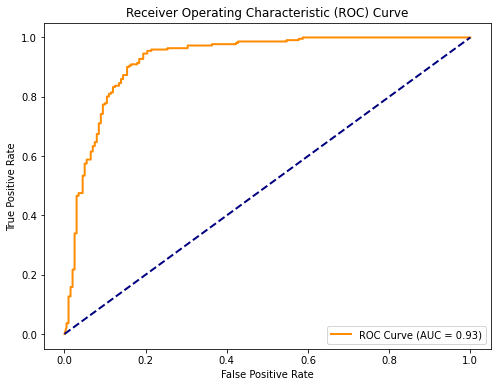

In [8]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


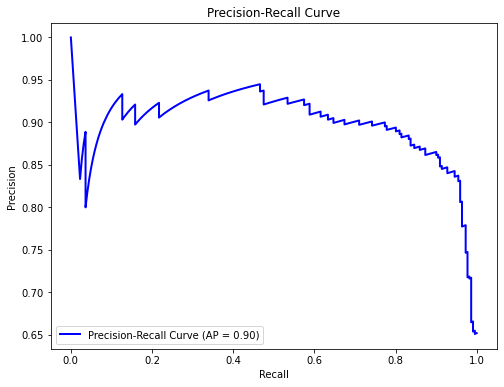

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and Average Precision
precision, recall, _ = precision_recall_curve(true_classes, predictions)
avg_precision = average_precision_score(true_classes, predictions)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# CAM Outputs

In [2]:
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


from classification_models.tfkeras import Classifiers
ResNet34, preprocess_input = Classifiers.get('resnet34')

# Step 3: Load the Pre-trained ResNet-34 model without the top layers
base_model = ResNet34(weights='imagenet', include_top=False, input_shape=(1792, 1792, 3))

# Freeze the base model layers initially
base_model.trainable = False

# Step 5: Build the model
inputs = layers.Input(shape=(1792, 1792, 3))
x = base_model(inputs, training=False)

# Capture the output of the last convolutional layer
last_conv_layer_output = x  # This is the output we need for Grad-CAM

# Multi-scale feature detection
x1 = layers.Conv2D(
    filters=128, kernel_size=(3, 3), activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01), padding='same'
)(x)

x2 = layers.Conv2D(
    filters=128, kernel_size=(5, 5), activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01), padding='same'
)(x)

x = layers.Concatenate()([x1, x2])

# Add dropout for regularization
x = layers.SpatialDropout2D(0.2)(x)

# Downsample with strided convolution
x = layers.Conv2D(
    filters=256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'
)(x)

# Flatten spatial features using Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

# Fully connected layers for classification
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout for fully connected layer
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

# Build the complete model
model = models.Model(inputs=inputs, outputs=outputs)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-80GB, compute capability 8.0


2024-11-22 17:46:55.475055: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 17:46:56.395567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


In [3]:
# Load weights from the saved model
from tensorflow.keras.layers import SpatialDropout2D

model = models.load_model(
    'after_finetuning_papa_BCC_model.h5',
    custom_objects={"SpatialDropout2D": SpatialDropout2D}
)

In [4]:
last_conv_layer_name = 'conv2d_2'
last_conv_layer_output = model.get_layer(last_conv_layer_name).output

In [5]:
from tensorflow.keras.models import Model

# Create a new model for Grad-CAM
model_with_conv_outputs = Model(inputs=model.input, outputs=[last_conv_layer_output, model.output])

In [ ]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def load_and_preprocess_image(img_path, target_size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Use the same preprocessing function as in your training
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

def make_gradcam_heatmap(img_array, model_with_conv_outputs, pred_index=None):
    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = model_with_conv_outputs(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class output value with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Handle possible None gradients
    if grads is None:
        print("Gradients are None. Check the computation graph.")
        return None

    # Pooled gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the importance of that channel
    conv_outputs = conv_outputs[0]  # Remove the batch dimension
    conv_outputs = tf.cast(conv_outputs, tf.float32)
    pooled_grads = tf.cast(pooled_grads, tf.float32)

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()


def display_gradcam_with_original(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB
    heatmap_rescaled = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Create a side-by-side display
    plt.figure(figsize=(15, 10))
    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')

    # Display the Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Grad-CAM')

    # Show the combined figure
    plt.tight_layout()
    plt.show()

# Specify the directory containing your images
present_dir = '/home/francokrepel/blue/vabfmc/data/working/d.uriartediaz/francokrepel/extended_organized_data/val/Present'  # Adjust this to your actual directory if needed

# Get list of all image paths in the "Present" directory
image_paths = glob.glob(os.path.join(present_dir, '*.png'))  # You can change '*.png' to match your image format

# Loop through each image in the directory
for img_path in image_paths:
    print(f"Processing {img_path}")

    # Step 1: Load and preprocess the image
    img_array = load_and_preprocess_image(img_path, target_size=(1792, 1792))

    # Step 2: Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model_with_conv_outputs)

    # Step 3: Display the Grad-CAM with the original image
    if heatmap is not None:
        display_gradcam_with_original(img_path, heatmap)
    else:
        print("Failed to generate Grad-CAM heatmap for image:", img_path)
        continue  # Skip to the next image if heatmap generation fails

    # Step 4: Make predictions
    prediction = model.predict(img_array)

    # Step 5: Interpret the prediction
    # Since this is a binary classification, the output is a probability
    if prediction[0][0] > 0.5:
        print(f"Prediction: Present (Confidence: {prediction[0][0]:.2f})")
    else:
        print(f"Prediction: Clear (Confidence: {1 - prediction[0][0]:.2f})")
